### Uppvärmning

Först måste vi göra ändringar till csv filens data som t.ex lägga till make $i$ kolunnen 

In [2]:
import pandas as pd
from ast import literal_eval as tolist
from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import loggamma
from statinlprojekt import Theta_MoM_skattning, AlphaBeta_MoM_skattning, tricks_data, get_parameters_tricks, get_avg_alpha_beta_tricks, Lcq_ids
from simulate import xparams, print_dic
from metro import metropolis


In [1]:

# pdf = lambda x: 2*np.exp(-2*x);
# Finv = lambda u: -(1/2)*np.log(u)
df = pd.read_csv("SLS22.csv") #data frame 
Lcq_ids = ["Majerus", "Oliveira","Decenzo","Santiago", "Papa", "Eaton", "Mota", "Shirai", 
           "Jordan", "Hoefler", "Hoban", "Gustavo", "Ribeiro C", "O’neill", "Foy", "Midler"]
Lcq_ids = ["Majerus", "Oliveira", "O’neill", "Santiago", "Papa", "Ribeiro C", "Mota", "Shirai",
           "Jordan", "Hoefler", "Foy", "Midler", "Gustavo", "Hoban", "Eaton", "Decenzo"]
def init_normal_dataframe():
    ndf = df
    ndf["run 1"] = [x/10 for x in df["run 1"]]
    ndf["run 2"] = [x/10 for x in df["run 2"]]
    ndf["trick 1"] = [x/10 for x in df["trick 1"]]
    ndf["trick 2"] = [x/10 for x in df["trick 2"]]
    ndf["trick 3"] = [x/10 for x in df["trick 3"]]
    ndf["trick 4"] = [x/10 for x in df["trick 4"]]
    ndf["trick 5"] = [x/10 for x in df["trick 5"]]
    ndf["trick 6"] = [x/10 for x in df["trick 6"]]
    ndf["make 1"] = [int(bool(x)) for x in df["trick 1"].values.tolist()]
    ndf["make 2"] = [int(bool(x)) for x in df["trick 2"].values.tolist()]
    ndf["make 3"] = [int(bool(x)) for x in df["trick 3"].values.tolist()]
    ndf["make 4"] = [int(bool(x)) for x in df["trick 4"].values.tolist()]
    return ndf
ndf = init_normal_dataframe()

ids = []
for name in ndf['id']:
    if name not in ids:
        ids.append(name)

In [ ]:
def make_histogram():
    plt.hist(ndf["trick 1"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 1")
    plt.hist(ndf["trick 2"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 2")
    plt.hist(ndf["trick 3"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 3")
    plt.hist(ndf["trick 4"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 4")
    plt.legend()
    plt.show()

def make_histogram_runs():
    # fig, ax = plt.subplots(1, 1)
    plt.hist(ndf["run 1"], density=True,
             histtype='stepfilled', alpha=0.5, label="run 1")
    plt.hist(ndf["run 2"], density=True,
             histtype='stepfilled', alpha=0.5, label="run 2")
    plt.legend()
    plt.show()

def calculate_Q1_partd():
    count_lands = ndf["make 1"].values.tolist().count(1) + ndf["make 2"].values.tolist().count(1) +ndf["make 3"].values.tolist().count(1) + ndf["make 4"].values.tolist().count(1) 
    count_bigger_than6 = 0;
    alltricks = ndf["trick 1"].values.tolist() + ndf["trick 2"].values.tolist() + ndf["trick 3"].values.tolist() + ndf["trick 4"].values.tolist()
    for x in alltricks:
        if x>0.6:
            count_bigger_than6+=1
    return float(count_bigger_than6)/float(count_lands)


def plot_run1_run2():
    plt.scatter(ndf["run 1"],ndf["run 2"],color='blue', marker='o')
    plt.xlabel('run 1')
    plt.ylabel('run 2')
    plt.legend()
    plt.show()

### En frekventistisk modell

['Gustavo', 'Hoban', 'Eaton', 'Decenzo']  has freq:  23
{'Shirai', 'Hoefler', 'Jordan', 'Hoban'}  has freq:  54


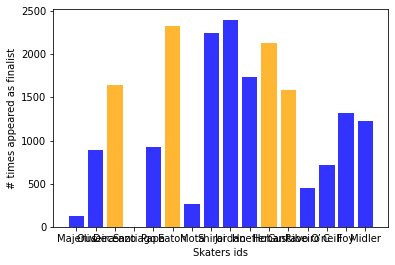

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from statinlprojekt import get_parameters_tricks, get_parameters_runs, Lcq_ids, ids, init_trick_data
import ast

#["Majerus", "Oliveira","Decenzo","Santiago", "Papa", "Eaton", "Mota", "Shirai","Jordan", "Hoefler", "Hoban", "Gustavo", "Ribeiro C", "O’neill", "Foy", "Midler"]

actual_finalists = ["Gustavo", "Hoban", "Eaton", "Decenzo"]

Lcq_ids_index = {Lcq_ids[e]:e for e in range(len(Lcq_ids))}

def get_LCQ_params():
    resultx = get_parameters_tricks()
    resulty = get_parameters_runs()
    for e in ids:
        if e not in Lcq_ids:
            resultx.pop(e)
            resulty.pop(e)
    return resultx, resulty
def print_dic(dic):
    for keys,values in dic.items():
        print(keys,values)

xparams, yparams = get_LCQ_params()

def sort_with_indices(arr):
    indexed_arr = list(enumerate(arr))
    sorted_arr = sorted(indexed_arr, key=lambda x: x[1])
    indices = [index for index, _ in sorted_arr]
    return indices

def total_betyg(tricks, runs):
    sorted_trick = sorted(tricks)
    return (sorted_trick[-2]+sorted_trick[-1]) + max(runs)


def sim_trick_betyg(theta,alpha,beta):
    V = np.array(np.random.choice([0,1], 4, p = [1-theta,theta]))
    Z = np.array(np.random.beta(alpha,beta,4))
    X = [0,0,0,0]
    for i in range(len(X)):
        X[i] = Z[i]*V[i]
    return X

def get_rand_LCQ(): # returns an array of n LCQs. An LCQ is an array representing 
    new_LCQ = {}
    for name in Lcq_ids:
        x_theta,x_alpha,x_beta = xparams[name][0],xparams[name][1],xparams[name][2]
        y_alpha,y_beta = yparams[name][0],yparams[name][1]
        skaters_tricks = sim_trick_betyg(x_theta,x_alpha,x_beta)
        skaters_runs = np.random.beta(y_alpha,y_beta,2)
        new_LCQ[name] = total_betyg(skaters_tricks, skaters_runs)
    return new_LCQ


def get_rand_finalists():
    rand_LCQ = get_rand_LCQ()
    sorted_players = sorted(rand_LCQ.items(), key = lambda x:x[1])
    return [sorted_players[-4][0],sorted_players[-3][0],sorted_players[-2][0],sorted_players[-1][0]]


def most_common_set(set_list):
    set_counts = Counter(frozenset(s) for s in set_list)
    most_common_set, count = set_counts.most_common(1)[0]
    return set(most_common_set), count

def most_common_array(arrays):
    tuple_arrays = [tuple(inner_list) for inner_list in arrays]
    array_counts = Counter(tuple_arrays)
    most_common_tuple, count = array_counts.most_common(1)[0]
    most_common_array = list(most_common_tuple)
    return most_common_array, count


def make_finalist_histogram():
    winner_count = {player : 0 for player in Lcq_ids}
    finalist_array = []
    for i in range(5000):
        new_W = get_rand_finalists()
        finalist_array.append(new_W)
        for e in new_W:
            winner_count[e] += 1
    
    def disp_least_to_greatest():
        winner_count_sorted = sorted(winner_count.items(), key = lambda x: x[1])
        for e in winner_count_sorted:
            print(e[0],e[1])

    def disp_most_common_finalists():
        finalist_array_sets = [set(finalists) for finalists in finalist_array]
        print(actual_finalists, " has freq: ", finalist_array_sets.count(set(actual_finalists)))
        most_common_finalists, freq = most_common_set(finalist_array_sets)
        print(most_common_finalists, " has freq: ", freq)

    
    disp_most_common_finalists()

    colors = ['orange' if x in actual_finalists else 'blue' for x in Lcq_ids]
    plt.bar(Lcq_ids, [winner_count[name] for name in Lcq_ids], color=colors, alpha=0.8)
    plt.xlabel("Skaters ids")
    plt.ylabel("# times appeared as finalist")
    plt.show()

if __name__=="__main__":
    make_finalist_histogram()


### En bayesiansk modell

We need a prior distribution for the parameters $\alpha$ and $\beta$ in a $\mathrm{Beta}(\alpha, \beta)$ distribution. To get this, we reparameterize the distribution according to its mean $\mu$ and a measure of precision $\kappa$. That is, for $X\sim\mathrm{Beta}(\alpha, \beta)$ we take
$$\mu = \frac{\alpha}{\alpha + \beta} \text{ och } \kappa = \alpha + \beta + 1$$

$\kappa$ is a measure of precision for the distribution since it is inverse-proportional to the variance:
$$
\mathrm{Var}[X] = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)} = \frac{\mu(1 - \mu)}{\kappa}.
$$

We can then specify a distribution $[\mu, \kappa]^T$ (according to a hierarki) and then transform this distribution back to the parameters $\alpha$ and $\beta$ to get a distribution for $[A, B]^T$.
We take the hierarchical model:
$$
\begin{split}
\kappa | \mu &\sim \mathrm{Gamma}(\theta, \lambda),\\
\mu &\sim \mathrm{U}(0,1)
\end{split}
$$

A transformation of variables gives us the prior distribution on the parameters $\alpha$ and $\beta$:
$$
f_{A, B}(\alpha, \beta) = \frac{\lambda^\theta}{\Gamma(\theta)}(\alpha + \beta + 1)^{\theta - 1}e^{-\lambda(\alpha + \beta + 1)}(\alpha + \beta)^{-1}.
$$

We see that the density function here has a singularity at $[\alpha, \beta]^T = [0,0]^T$ where the value of $f_{A, B}(\alpha, \beta)$ tends towards infinity.  This can be a problem for us if we do not have much data and the prior distribution dominates the posterior.  In particular, the posterior distribution will have a MAP-estimate of $[0,0]^T$ which are parameter values we cannot take!  A good choice of $\theta$ and $\lambda$ can help us avoid this.  Sometimes identifying this choice takes some experimentation.  In this case, $\theta = 3$ and $\lambda = 1$ works:

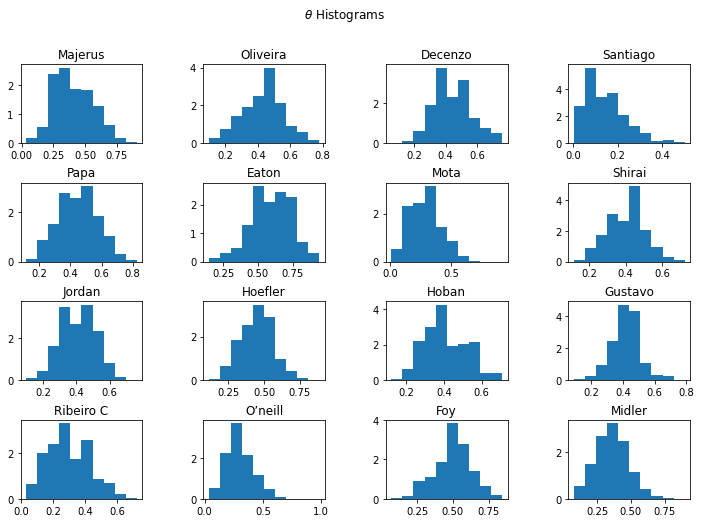

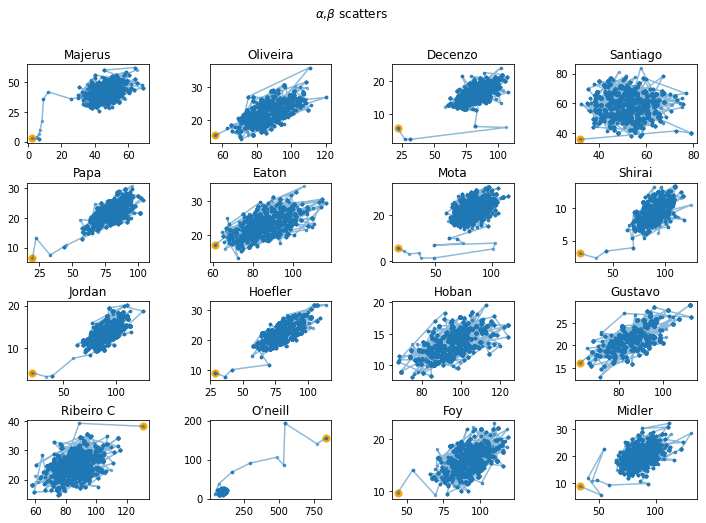

In [3]:
metro_df = pd.read_json('metro_results.json')
metro_df.set_index('ids',inplace=True)

def make_hists():
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    fig.suptitle(r"$\theta$ Histograms")
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    c = 0
    for i in range(4):
        for j in range(4):
            thetas = metro_df.loc[Lcq_ids[c]]['thetas']
            axes[i,j].hist(thetas, density=True)
            axes[i,j].set_title(Lcq_ids[c])
            c+=1
    plt.show()

def make_scatters():
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    fig.suptitle(r"$\alpha$,$\beta$ scatters")
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    c = 0
    for i in range(4):
        for j in range(4):
            alphas = metro_df.loc[Lcq_ids[c]]['alphas']
            betas = metro_df.loc[Lcq_ids[c]]['betas']
            axes[i,j].scatter(alphas[0],betas[0], marker='o',s=50,alpha=1, color='orange')
            axes[i,j].plot(alphas, betas, '.-', markersize=5, alpha=0.5)
            axes[i,j].set_title(Lcq_ids[c])
            c+=1
    plt.show()

make_hists()
make_scatters()